<a href="https://colab.research.google.com/github/gperera-cyber/CS6260_D3/blob/master/Gaussian_Mixture_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

In [ ]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [ ]:
iris = datasets.load_iris()
X = iris.data
X[:20]    

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

In [ ]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [ ]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [ ]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [ ]:
initialize_clusters(X, 4)

[{'cov_k': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'mu_k': array([5.006, 3.428, 1.462, 0.246]),
  'pi_k': 0.25},
 {'cov_k': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'mu_k': array([6.9125  , 3.1     , 5.846875, 2.13125 ]),
  'pi_k': 0.25},
 {'cov_k': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'mu_k': array([5.53214286, 2.63571429, 3.96071429, 1.22857143]),
  'pi_k': 0.25},
 {'cov_k': array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  'mu_k': array([6.2525, 2.855 , 4.815 , 1.625 ]),
  'pi_k': 0.25}]

Step 2 (Expectation step)

In [ ]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

Step 3 (Maximization step):

In [ ]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [ ]:
def get_likelihood(X, clusters):
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [ ]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [ ]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

# New Code

##### https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Clustering_gmm.csv to Clustering_gmm.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Clustering_gmm.csv']))


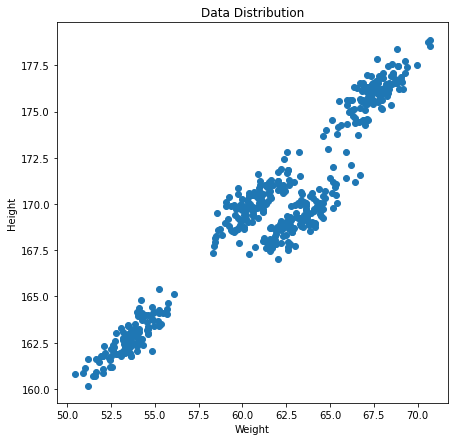

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()

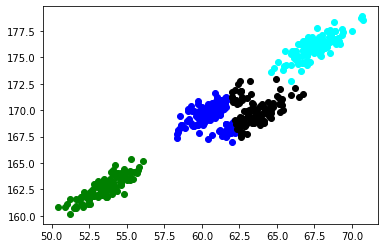

In [ ]:
# training k-means model
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

#predictions from kmeans
pred = kmeans.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = pred
frame.columns = ['Weight', 'Height', 'cluster']

#plotting results
color=['blue','green','cyan', 'black']
for k in range(0,4):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Weight"],data["Height"],c=color[k])
plt.show()

In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Clustering_gmm.csv']))

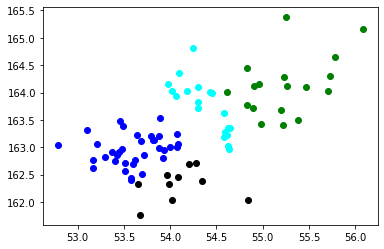

In [ ]:
#Gaussiam Mixture Model
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
gmm.fit(data)

#predictions from gmm
labels = gmm.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['Weight', 'Height', 'cluster']

color=['blue','green','cyan', 'black']
for k in range(0,4):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Weight"],data["Height"],c=color[k])

plt.show()


#### https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

In [ ]:
# Gaussian Mixture Model Selection
from sklearn import datasets
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

In [ ]:
X=np.array(X)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']



for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


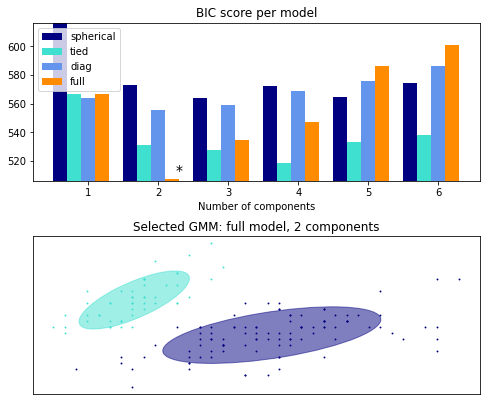

In [ ]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [ ]:
best_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

#### https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']




Automatically created module for IPython interactive environment


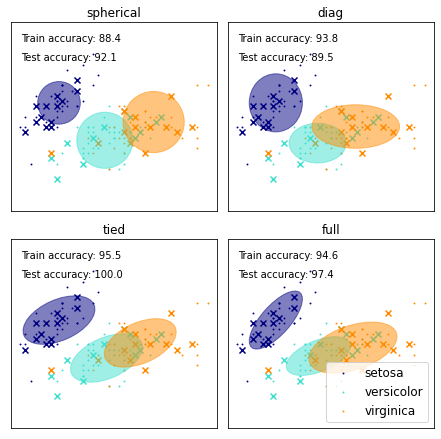

In [ ]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

In [ ]:
# ADNI data

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()



Saving UPENNROI_MARS_06_01_16.csv to UPENNROI_MARS_06_01_16.csv


In [ ]:
import io
upennADNI = pd.read_csv(io.BytesIO(uploaded['UPENNROI_MARS_06_01_16.csv']))

In [ ]:
uploaded_labels= files.upload()

Saving UPENNSPARE_AD_07_27_16.csv to UPENNSPARE_AD_07_27_16.csv


In [ ]:
upennADNI_labels = pd.read_csv(io.BytesIO(uploaded_labels['UPENNSPARE_AD_07_27_16.csv']))

In [ ]:
result = pd.concat([upennADNI, upennADNI_labels], axis=1, join="inner")

In [ ]:
result.head()

,RID,VISCODE,EXAMDATE,VERSION,IMAGE_UID,RUNDATE,STATUS,CBICA_ID,DATE,R702,R701,R601,R604,R606,R607,R613,R614,R501,R502,R503,R504,R505,R506,R507,R508,R509,R510,R511,R512,R513,R514,R515,R516,R517,R518,R519,R520,R521,R522,R523,...,R179,R180,R181,R182,R183,R184,R185,R186,R187,R190,R191,R192,R193,R194,R195,R196,R197,R198,R199,R200,R201,R202,R203,R204,R205,R206,R207,update_stamp,RID,VISCODE,EXAMDATE,VERSION,IMAGE_UID,RUNDATE,STATUS,CBICA_ID,DATE,TrueLabel,SPARE_AD,update_stamp
0,2,sc,2005-08-26,2016-03-21,I35475,2016-03-21,COMPLETE,011_S_0002_2005-08-26,2005-08-26,1784710,1481370,769408,559495,376882,271406,381640,273394,14695.3,147062.0,59483.2,443410,43991.7,146207.0,217624,245458,129609.0,68156.9,29360.4,217639,23239.1,72638.7,109252.0,122437.0,61954.7,68019.5,30122.8,225771,20752.6,73568.6,108373.0,...,3742.05,1605.62,1878.55,15226.10,15984.7,1496.440,1633.850,1897.38,2168.43,16918.3,17307.9,6134.48,5281.79,10766.90,10426.20,3772.17,3604.64,12419.50,12577.70,7531.16,6862.94,8957.96,9767.36,3077.59,2563.72,1338.33,1044.69,2016-06-02 09:02:36.0,2,sc,2005-08-26,2016-07-25,I35475,2016-07-25,COMPLETE,011_S_0002_2005-08-26,2005-08-26,CN,-2.762380,2016-08-12 09:49:21.0
1,3,sc,2005-09-01,2016-03-21,I32237,2016-03-21,COMPLETE,011_S_0003_2005-09-01,2005-09-01,1785950,1375710,650866,608196,315253,297334,326034,298009,12853.3,138833.0,60011.0,421145,35191.9,139147.0,206586,235162,92995.2,64731.0,30063.8,207928,17917.5,67087.3,103274.0,116441.0,51452.7,64522.3,29947.2,213216,17274.4,72059.4,103312.0,...,3264.57,1794.01,1775.20,14056.80,13285.8,991.031,964.704,1649.21,1878.63,13878.2,12968.0,4453.06,5780.70,8614.63,7933.89,3623.75,1852.31,8595.83,9596.26,6754.81,5647.18,8133.22,7992.18,3008.82,3520.32,1148.99,1203.53,2016-06-02 09:02:36.0,3,sc,2005-09-01,2016-07-25,I32237,2016-07-25,COMPLETE,011_S_0003_2005-09-01,2005-09-01,AD,6.246470,2016-08-12 09:49:21.0
2,4,sc,2005-09-22,2016-03-21,I64631,2016-03-21,COMPLETE,022_S_0004_2005-09-22,2005-09-22,1619320,1314280,710294,536895,349263,260243,350268,263184,13466.6,144443.0,54311.4,408553,37021.4,139417.0,205510,235740,46219.8,66220.8,26933.2,202818,18654.9,68075.9,105472.0,117027.0,22303.0,67459.4,27378.2,205736,18366.5,71341.2,100037.0,...,3221.96,1815.53,1734.47,14611.00,15233.1,1753.320,2744.980,1915.45,1900.37,12916.1,14839.1,3681.97,5199.63,7974.77,7859.77,4647.24,4253.21,8753.40,10444.50,7522.30,7652.39,8225.52,8943.81,2867.52,2141.69,1515.77,1755.20,2016-06-02 09:02:36.0,4,sc,2005-09-22,2016-07-25,I64631,2016-07-25,COMPLETE,022_S_0004_2005-09-22,2005-09-22,MCI,0.073087,2016-08-12 09:49:21.0
3,5,sc,2005-09-02,2016-03-21,I32246,2016-03-21,COMPLETE,011_S_0005_2005-09-02,2005-09-02,1655680,1284970,674370,550245,328666,266316,335780,269504,14424.7,146248.0,53464.8,394955,36230.1,132689.0,210218,227417,39696.6,68008.0,25900.1,194911,18826.0,66416.8,105779.0,110579.0,18331.3,68316.5,27564.7,200044,17404.0,66271.9,104439.0,...,3711.03,1378.71,1453.94,11261.00,11855.4,1367.420,2025.740,1581.84,1610.06,12745.0,12506.2,4130.48,4499.13,9404.54,8456.57,2548.63,2618.22,10309.30,10243.40,5616.39,5902.29,8467.85,7683.51,2973.72,2405.68,1724.79,1643.91,2016-06-02 09:02:36.0,5,sc,2005-09-02,2016-07-25,I32246,2016-07-25,COMPLETE,011_S_0005_2005-09-02,2005-09-02,CN,0.189799,2016-08-12 09:49:21.0
4,6,sc,2005-11-15,2016-03-21,I33025,2016-03-21,COMPLETE,100_S_0006_2005-11-15,2005-11-15,1528520,1111110,573425,471989,282038,232259,280417,229241,10488.8,129739.0,47050.7,330776,30439.7,114383.0,179214,194565,45678.7,58831.5,23678.8,164443,15426.6,56395.6,92550.3,98511.6,22138.4,59937.0,23371.8,166333,15013.0,57987.2,86663.6,...,3081.92,1006.34,1299.50,8366.27,10412.0,1002.080,1183.300,1300.57,1308.03,12055.8,11143.3,3748.19,3348.43,7204.29,6955.90,2535.04,2435.90,9269.21,8364.14,5948.50,6253.38,5931.44,6659.54,2321.83,2245.08,1261.12,1250.46,2016-06-02 09:02:36.0,6,sc,2005-11-15,2016-07-25,I33025,2016-07-25,COMPLETE,100_S_0006_2005-11-15,2005-11-15,MCI,0.014138,2016-08-12 09:49:21.0


In [ ]:
upennADNI.iloc[:,9:268].head()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = upennADNI.iloc[:, 9:268].values

# Standardizing the features
xstd = StandardScaler().fit_transform(x)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(xstd)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf=pd.concat([principalDf, result.loc[:,'TrueLabel']], axis=1, join="inner")

In [ ]:
principalDf.head()

,principal component 1,principal component 2,TrueLabel
0,25.521945,-1.129479,CN
1,12.032488,10.589438,AD
2,15.798575,-4.928229,MCI
3,11.061581,-2.465446,CN
4,-6.337004,-0.903119,MCI


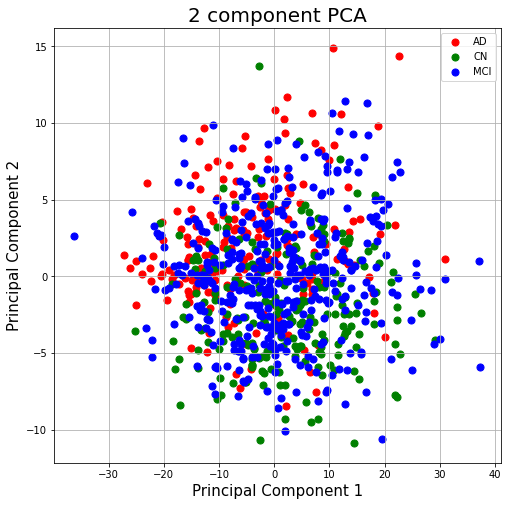

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['AD', 'CN', 'MCI']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['TrueLabel'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


In [ ]:
#Training a gaussian mixture model

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)

# Separating out the features
features=x
gmm.fit(features)

#predictions from gmm
labels = gmm.predict(x)
frame = pd.DataFrame(x)
frame['cluster'] = labels

dataframe=pd.DataFrame(frame)


In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
X=np.array(x)

lowest_bic = np.infty
bic = []
n_components_range = range(5, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']



for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


best_gmm

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
#Training a gaussian mixture model

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5,covariance_type='tied')

# Separating out the features
features=x
gmm.fit(features)

#predictions from gmm
labels = gmm.predict(x)
frame = pd.DataFrame(x)
frame['cluster'] = labels

dataframe=pd.DataFrame(frame)
dataframe_lbl=pd.concat([dataframe, result.loc[:,'TrueLabel']], axis=1, join="inner")

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [ ]:
agg_df = dataframe.groupby('cluster').agg('mean')

In [ ]:
agg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.544033e+06,1.188387e+06,613660.870293,505989.949791,301300.631799,247255.556485,302856.682008,247355.280335,11379.172678,135740.397490,52385.918828,362366.866109,33270.007950,121781.702092,184021.485356,209473.004184,48173.666109,62989.898326,26083.415063,179151.912134,17169.885356,60793.697071,93566.043933,104106.076151,23206.950962,63246.988703,26302.500418,183214.958159,16100.120921,60987.984937,90455.453975,105366.936820,21284.756862,17719.650628,14021.340167,11111.881925,173430.782427,188936.075314,33270.007950,73290.679498,...,3595.090209,3951.032176,9827.381004,9822.022050,3092.168452,3224.915858,1868.326485,1727.540293,1685.184615,1851.249276,8580.514351,9589.384268,3247.370167,2909.661925,1322.313837,1432.131067,11337.441715,11351.440795,1318.559218,1492.944477,1335.386209,1425.158640,11684.739749,11878.115230,3962.563556,4437.842971,7487.496695,7120.690126,3266.078996,2841.002715,8739.632218,8617.751925,6161.545732,6081.314477,7771.861506,7677.536234,2711.099498,2848.700042,1129.056071,1273.007021
1,1.321030e+06,1.011701e+06,527302.858209,425922.291045,258417.082090,207499.985075,260593.746269,208965.298507,9456.957313,118739.956716,46618.496269,307563.238806,28267.618657,102685.202239,155650.261194,176277.477612,40623.594627,55128.322388,23182.852239,151970.067164,14536.542537,50650.373134,79005.497761,87390.048507,19230.689179,55319.630597,23435.655970,155593.171642,13731.082836,52034.823881,76644.746269,88887.440299,18193.335075,16258.520896,12422.994925,9734.650672,148703.432090,158859.694030,28267.618657,61972.795522,...,2993.153433,3226.691269,8133.869701,7958.010149,2657.808955,2758.967761,1518.210522,1419.245343,1371.449224,1516.613761,7563.633134,8527.786045,2818.592239,2505.177239,1166.694284,1256.855448,9915.349179,9826.496940,1106.889746,1242.211299,1084.791687,1159.969403,10041.574701,10279.584030,3487.187836,3950.557015,6663.431716,6310.832388,2931.606119,2590.785075,7574.012910,7427.426791,5291.466493,5416.892463,6564.052537,6452.786642,2521.169925,2430.031194,916.391985,1021.216784
2,1.660721e+06,1.291877e+06,660906.136364,547863.125000,323903.170455,267515.312500,327313.664773,267916.096591,12431.650398,141879.340909,55861.044318,395612.647727,35931.314773,133297.431818,197425.272727,226547.460227,61611.614773,65827.631250,27767.676705,195228.840909,18529.969886,66395.023295,100329.965909,112367.680114,30490.254261,66362.346023,28093.367045,200383.789773,17401.335795,66902.442045,97095.345455,114179.775568,26810.898864,18965.523864,14922.593750,11859.615795,188912.454545,206700.153409,35931.314773,80643.519318,...,3913.328977,4194.064034,10929.942102,10751.614432,3277.262557,3377.837784,2037.978523,1852.502500,1829.495375,1990.413011,9051.974943,10083.423977,3570.344830,3170.119148,1424.260227,1536.047386,12487.280398,12423.845625,1384.913375,1599.204063,1647.839733,1697.040528,12558.322443,12973.731193,4544.855227,5101.296250,7831.908295,7518.999091,3516.163750,3095.220057,9422.436932,9408.090625,6487.498352,6530.905682,8593.741648,8196.938125,2891.409545,2922.563523,1250.461864,1390.201875
3,1.805803e+06,1.408146e+06,712619.073529,607352.279412,349673.647059,296389.441176,352557.191176,297444.676471,13518.320588,152755.808824,60366.029412,435193.235294,38538.285294,145892.338235,217082.029412,245974.367647,64602.776471,70888.752941,29997.060294,214418.764706,19943.547059,72824.198529,110352.132353,122224.191176,31635.312353,71478.779412,30368.975000,220774.529412,18594.741176,73068.105882,106729.951471,123750.073529,28428.068824,20121.123529,15971.360294,13292.316176,204814.544118,230378.676471,38538.285294,87369.094118,...,4225.866029,4

In [ ]:
agg_df_lbl=dataframe_lbl.groupby(['cluster','TrueLabel']).agg({'TrueLabel': ['count']})
agg_df_lbl

In [ ]:
agg_df_lbl['cluster']=[0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]

In [ ]:
agg_df_lbl['count']=agg_df_lbl.iloc[:,0]
agg_df_lbl['Truelabel']=['AD','CN','MCI','AD','CN','MCI','AD','CN','MCI','AD','CN','MCI','AD','CN','MCI']

In [ ]:
agg_df_lbl

TrueLabel cluster count Truelabel
                      count                        
cluster TrueLabel                                  
0       AD               64       0    64        AD
        CN               47       0    47        CN
        MCI              91       0    91       MCI
1       AD               33       1    33        AD
        CN               59       1    59        CN
        MCI              99       1    99       MCI
2       AD               22       2    22        AD
        CN               25       2    25        CN
        MCI              57       2    57       MCI
3       AD               53       3    53        AD
        CN               75       3    75        CN
        MCI             133       3   133       MCI
4       AD               28       4    28        AD
        CN               24       4    24        CN
        MCI              30       4    30       MCI

In [ ]:
agg_df_lbl=agg_df_lbl.pivot(index='cluster', columns='Truelabel', values='count')
#agg_df_lbl['cluster']=agg_df_lbl.index

In [ ]:
agg_df_lbl

Truelabel,AD,CN,MCI
cluster,,,
0,64,47,91
1,33,59,99
2,22,25,57
3,53,75,133
4,28,24,30


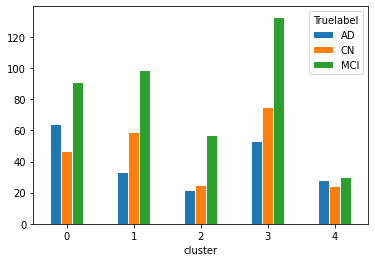

In [ ]:
#rearrange dataframe and plot
agg_df_lbl.plot.bar(edgecolor = "white")
plt.xticks(rotation = 0)
plt.show()

## MSCS algorithm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import numpy as np
import bisect

In [ ]:
uploaded = files.upload()

In [ ]:
import io
heart = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

In [ ]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
y=heart['target']
X=heart.iloc[:,0:13]

In [ ]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [ ]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.html

Optimization terminated successfully.
         Current function value: 0.351932
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.489     
Dependent Variable: target           AIC:              239.2711  
Date:               2021-06-30 11:53 BIC:              287.5496  
No. Observations:   303              Log-Likelihood:   -106.64   
Df Model:           12               LL-Null:          -208.82   
Df Residuals:       290              LLR p-value:      4.0884e-37
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
age            0.0128    0.0191   0.6701  0.5028  -0.0246   0.0501
sex           -1.6381    0.4519  -3.6250  0.0003  -2.5237  -0.

In [ ]:
result.llf

-106.63552976793433

In [ ]:
from scipy.stats import bernoulli
t=0
w0=[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
a_star=0.05
epsilon=0.2

In [ ]:
#bernoulli probability mass function:
def pmf(u,w):
    p = w**u*(1-w)**(1-u)
    return p

In [ ]:
# i gets added to the end of the var name
i = 1
for n in range(300):
  vj=[]
  #uj=[]
  for w in range(13):
    ber=int(bernoulli.rvs(size=1,p=w0[w]))
    if ber==0:
      apnd=np.nan
    else:
      apnd=w
    
    vj.append(apnd)
    #uj.append(ber)
  #globals()["u" + str(i)] = uj
  globals()["v" + str(i)] = vj
  i += 1

In [ ]:
# Step 1

i = 1
for n in range(300):
  vj=[]
  #uj=[]
  for w in range(13):
    ber=int(bernoulli.rvs(size=1,p=w0[w]))
    if ber==0:
      apnd=np.nan
    else:
      apnd=w
    
    vj.append(apnd)
    #uj.append(ber)
  #globals()["u" + str(i)] = uj
  globals()["v" + str(i)] = vj
  i += 1


i = 1
pval=[]
pval_st3=[]
modelno=[]
nar=list(range(1, 301, 1))
for n in nar:
  incoms=globals()["v" + str(i)]
  a=[incom for incom in incoms if str(incom) != 'nan']
  globals()["X" + str(i)] = X.iloc[:,a]
  logit_model=sm.Logit(y,globals()["X" + str(i)])
  result=logit_model.fit()
  #pval.append(result.llr_pvalue)
  pval_st3.append(result.llr_pvalue)
  modelno.append(n)
  bisect.insort(pval, result.llr_pvalue)
  i += 1

In [ ]:
# Step 2
pval_cleaned=[incom for incom in pval if str(incom) != 'nan']
a_t=min(np.percentile(pval_cleaned, 25),a_star)

In [ ]:
# Step 3
df1 = pd.DataFrame(modelno)
df2= pd.DataFrame(pval_st3)
allmodels=pd.concat([df1, df2], axis=1)
allmodels.columns=['modelno','pval']
allmodels.index = np.arange(1,len(allmodels)+1)
var=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nar=list(range(1, 301, 1))
sub3 = allmodels.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)
denom=len(sub3[sub3 == True].index)
cj=[]
epsilonj=[]
for j in var:
  #print(j)
  modlnum=[]
  for n in nar:
    #print(n)
    a=globals()["v" + str(n)]
    if j in a:
      modlnum.append(n)
  sub1=allmodels[allmodels.modelno.isin(list(modlnum))]
  sub2 = sub1.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)

  numr=len(sub2[sub2 == True].index) 
  c=numr/denom
  cj.append(c)
  e=epsilon*c+(1-epsilon)*w0[j]
  epsilonj.append(e)


In [ ]:
#While
Convergence=0
while True:
# Step 1

  i = 1
  for n in range(300):
    vj=[]
    #uj=[]
    for w in range(13):
      ber=int(bernoulli.rvs(size=1,p=w0[w]))
      if ber==0:
        apnd=np.nan
      else:
        apnd=w
    
      vj.append(apnd)
    #uj.append(ber)
    #globals()["u" + str(i)] = uj
    globals()["v" + str(i)] = vj
    i += 1


  k = 1
  pval=[]
  pval_st3=[]
  modelno=[]
  nar=list(range(1, 301, 1))
  for n in nar:
    incoms=globals()["v" + str(k)]
    a=[incom for incom in incoms if str(incom) != 'nan']
    globals()["X" + str(k)] = X.iloc[:,a]
    if len(a) == 0:   
      intce=list(range(1, len(y)+1, 1)) 
      logit_model=sm.Logit(y,intce)
    else:
      logit_model=sm.Logit(y,globals()["X" + str(k)])
    result=logit_model.fit()
    #pval.append(result.llr_pvalue)
    pval_st3.append(result.llr_pvalue)
    modelno.append(n)
    bisect.insort(pval, result.llr_pvalue)
    k += 1

  # Step 2
  pval_cleaned=[incom for incom in pval if str(incom) != 'nan']
  a_t=min(np.percentile(pval_cleaned, 25),a_star)
  Convergence += (a_t)
  if Convergence==0.5:
    break
  else:
    continue
  # Step 3
  df1 = pd.DataFrame(modelno)
  df2= pd.DataFrame(pval_st3)
  allmodels=pd.concat([df1, df2], axis=1)
  allmodels.columns=['modelno','pval']
  allmodels.index = np.arange(1,len(allmodels)+1)
  var=[0,1,2,3,4,5,6,7,8,9,10,11,12]
  nar=list(range(1, 301, 1))
  sub3 = allmodels.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)
  denom=len(sub3[sub3 == True].index)
  cj=[]
  epsilonj=[]
  for j in var:
    #print(j)
    modlnum=[]
    for n in nar:
      #print(n)
      a=globals()["v" + str(n)]
      if j in a:
        modlnum.append(n)
    sub1=allmodels[allmodels.modelno.isin(list(modlnum))]
    sub2 = sub1.apply(lambda x : True
              if x['pval'] > a_t else False, axis = 1)

    numr=len(sub2[sub2 == True].index) 
    c=numr/denom
    cj.append(c)
    e=epsilon*c+(1-epsilon)*w0[j]
    epsilonj.append(e)









Streaming output truncated to the last 5000 lines.
         Current function value: 0.417622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442313
         Iterations 6
Optimization terminated successfully.
         Current function value

In [ ]:
X152.head()

,sex,thalach,ca
0,1,150,0
1,1,187,0
2,0,172,0
3,1,178,0
4,0,163,0


In [ ]:
v153

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
a

[]

In [ ]:
list(range(1, len(y)+1, 1))

In [ ]:
len(X)

303

In [ ]:
# Step 3
df1 = pd.DataFrame(modelno)
df2= pd.DataFrame(pval_st3)
allmodels=pd.concat([df1, df2], axis=1)
allmodels.columns=['modelno','pval']
allmodels.index = np.arange(1,len(allmodels)+1)
var=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nar=list(range(1, 301, 1))
sub3 = allmodels.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)
denom=len(sub3[sub3 == True].index)
cj=[]
epsilonj=[]
for j in var:
  #print(j)
  modlnum=[]
  for n in nar:
    #print(n)
    a=globals()["v" + str(n)]
    if j in a:
      modlnum.append(n)
  sub1=allmodels[allmodels.modelno.isin(list(modlnum))]
  sub2 = sub1.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)

  numr=len(sub2[sub2 == True].index) 
  c=numr/denom
  cj.append(c)
  e=epsilon*c+(1-epsilon)*w0[j]
  epsilonj.append(e)
  w0[j]=e

In [ ]:
i=1
for n in range(300):
  a=globals()["v" + str(i)]
  v_cleaned=[incom for incom in a if str(incom) != 'nan']
  sub1=allmodels.iloc[v_cleaned,:]
  sub2 = sub1.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)

  nume=len(sub2[sub2 == True].index)

  sub3 = allmodels.apply(lambda x : True
            if x['pval'] > a_t else False, axis = 1)
  denom=len(sub3[sub3 == True].index)



  i +=1

  


In [ ]:
v300

[0, nan, 2, 3, nan, 5, nan, nan, nan, nan, 10, 11, nan]

In [ ]:
a

[0, nan, 2, 3, nan, 5, nan, nan, nan, nan, 10, 11, nan]

In [ ]:
v_cleaned

[0, 2, 3, 5, 10, 11]

In [ ]:
nume

5

In [ ]:
a_t

1.1150407070521823e-31

In [ ]:
sub2

0      True
2      True
3      True
5      True
10    False
11     True
dtype: bool